In [12]:
import torch
import os
import torchvision # To Download MNIST Datasets from Torch 
import torchvision.transforms as transforms # To Transform MNIST "Images" to "Tensor"
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image # Load 'save_image' Function


In [13]:
# ================================================================== #
#                        0. Define Hyper-parameters
# ================================================================== #
# Device Configuration for Where the Tensors Be Operated
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define OS Configuration
sample_dir = './results'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 28*28
h_dim = 256
h_dim2 = 128
z_dim = 2
num_epochs = 20
batch_size = 128
learning_rate = 0.001

In [14]:
# ================================================================== #
#                        1. Load Data
# ================================================================== #
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

# Doesn't Need Test Data (Going to be Sampled from z~N(0,1))


In [15]:
# ================================================================== #
#                        2. Define Dataloader
# ================================================================== #
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

# Doesn't Need Test Loader As Well

In [16]:
# ================================================================== #
#                        3. Define Model
# ================================================================== #
class VAE(nn.Module):
    def __init__(self, image_size=image_size, h_dim=h_dim,h_dim2=h_dim2, z_dim=z_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim) # from 784 Nodes(28x28 MNIST Image) to 400 Nodes (h_dim) 
        self.fc2 = nn.Linear(h_dim, h_dim2) # from 400 Nodes (h_dim) to 20 Nodes (Dims of mean of z)
        self.fc3 = nn.Linear(h_dim, h_dim2)# from 400 Nodes (h_dim) to 20 Nodes (Dims of std of z)
        self.fc4 = nn.Linear(h_dim2, z_dim)
        self.fc5 = nn.Linear(h_dim2, z_dim)
        self.fc6 = nn.Linear(z_dim, h_dim2) # from 20 Nodes (reparameterized z=mean+eps*std) to 400 Nodes (h_dim)
        self.fc7 = nn.Linear(h_dim2, h_dim)
        self.fc8 = nn.Linear(h_dim, image_size) # from 400 Nodes (h_dim) to 784 Nodes (Reconstructed 28x28 Image)
        
    # Encoder: Encode Image to Latent Vector z
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h_mu = F.relu(self.fc2(h))
        h_log_var = F.relu(self.fc3(h))
        return self.fc4(h_mu), self.fc5(h_log_var) # 784 -> 256
    
    # Reparameterize z=mean+std to z=mean+esp*std
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    # Decoder: Decode Reparameterized Latent Vector z to Reconstructed Image
    def decode(self, z):
        h = F.relu(self.fc6(z))
        h = F.relu(self.fc7(h))
        return torch.sigmoid(self.fc8(h))
    
    # Feed Forward the Process and Outputs Estimated (Mean, Std, Reconstructed_Image) at the same time
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)


In [17]:
# ================================================================== #
#                        4. Set Loss & Optimizer
# ================================================================== #
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Total Loss is going to be defined in Training Part as it is a combination of Reconstruction Loss and Regularization Loss


In [18]:
import matplotlib.pyplot as plt

In [19]:
import numpy as np


def plt_manifold(trained_model_instance, save_file_path, mean_range=3, n=20, figsize=(8, 10)): #
    x_axis = np.linspace(-mean_range, mean_range, n)
    y_axis = np.linspace(-mean_range, mean_range, n)
    canvas = np.empty((28*n, 28*n))

    for i, yi in enumerate(x_axis):
        for j, xi in enumerate(y_axis):
            z_mean = np.array([[xi, yi]] * 1)
            z_mean = torch.tensor(z_mean, device=device).float()
            x_reconst = model.decode(z_mean)
    
            canvas[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = x_reconst[0].reshape(28, 28).cpu()

    plt.figure(figsize=figsize)
    xi, yi = np.meshgrid(x_axis, y_axis)
    plt.imshow(canvas, origin="upper")
    plt.savefig(save_file_path)
    plt.show()

    return



In [20]:

# ================================================================== #
#                        5. Train / Test
# ================================================================== #
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader): # '_' as we don't need label of the input Image
        # Feed Forward
        x = x.to(device).view(-1, image_size) # Flatten 2D Image into 1D Nodes
        x_reconst, mu, log_var = model(x)
        
        # Compute the Total Loss
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False) # See the Description below
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        
        # Get Loss, Compute Gradient, Update Parameters
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print Loss for Tracking Training
        if (i+1) % 50 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(train_loader), reconst_loss.item(), kl_div.item()))
            
    # Save Model on Last epoch
    if epoch+1 == num_epochs:
        torch.save(model.state_dict(), './model.pth')
    
    # Save Generated Image and Reconstructed Image at every Epoch
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device) # Randomly Sample z (Only Contains Mean)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))


Epoch[1/20], Step [50/469], Reconst Loss: 26158.0781, KL Div: 189.8601
Epoch[1/20], Step [100/469], Reconst Loss: 24532.5293, KL Div: 190.9143
Epoch[1/20], Step [150/469], Reconst Loss: 22899.6699, KL Div: 310.8943
Epoch[1/20], Step [200/469], Reconst Loss: 21981.3828, KL Div: 358.7204
Epoch[1/20], Step [250/469], Reconst Loss: 22211.4434, KL Div: 352.7770
Epoch[1/20], Step [300/469], Reconst Loss: 20966.8359, KL Div: 358.2585
Epoch[1/20], Step [350/469], Reconst Loss: 21584.6719, KL Div: 329.7017
Epoch[1/20], Step [400/469], Reconst Loss: 21720.2344, KL Div: 407.6901
Epoch[1/20], Step [450/469], Reconst Loss: 21254.7988, KL Div: 388.0808
Epoch[2/20], Step [50/469], Reconst Loss: 21333.1133, KL Div: 356.3707
Epoch[2/20], Step [100/469], Reconst Loss: 20029.0508, KL Div: 408.9708
Epoch[2/20], Step [150/469], Reconst Loss: 20020.2129, KL Div: 376.3825
Epoch[2/20], Step [200/469], Reconst Loss: 19328.9844, KL Div: 420.0394
Epoch[2/20], Step [250/469], Reconst Loss: 19889.2891, KL Div: 400

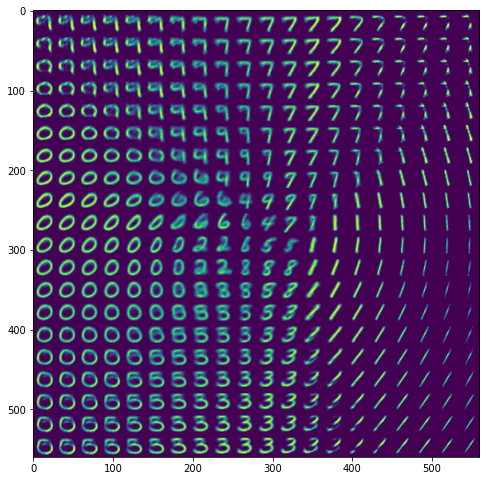

In [21]:
save_file_path = "./mnist_manifold.png"
with torch.no_grad():
    plt_manifold(model, save_file_path)

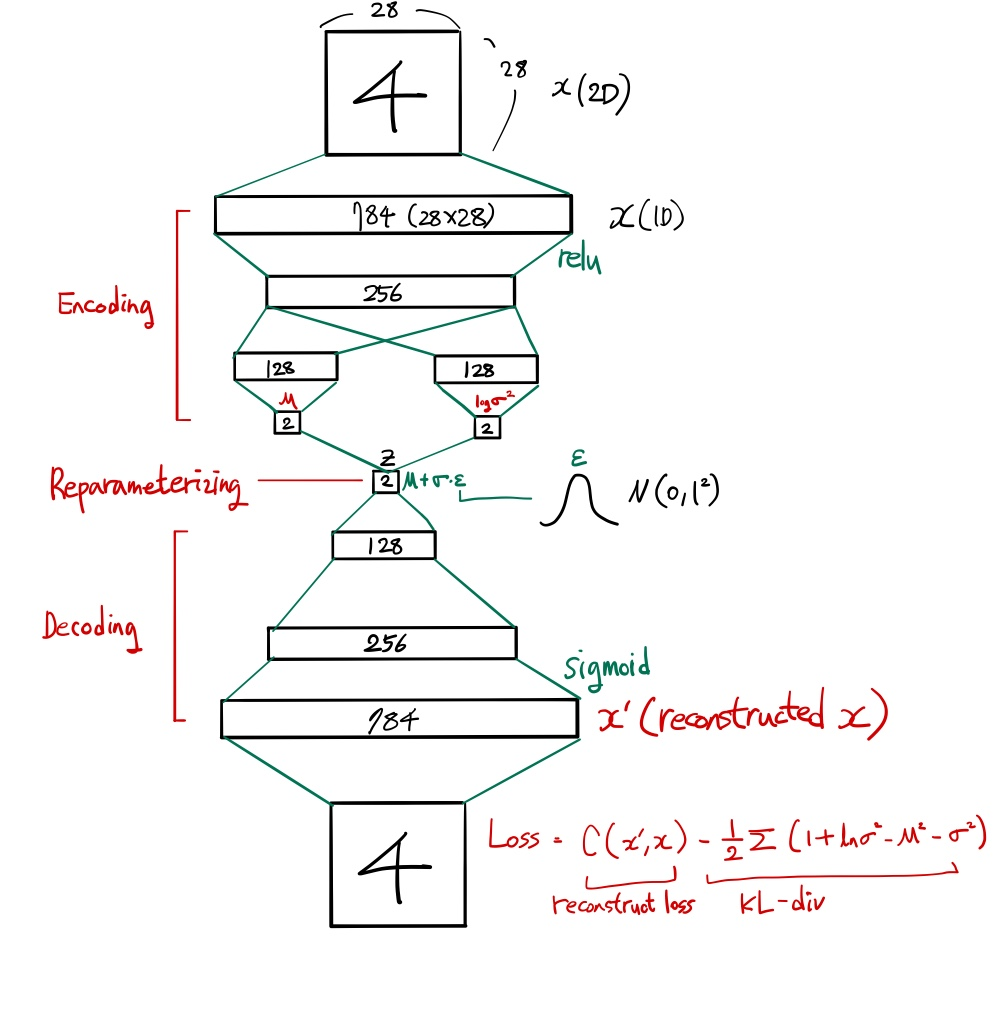